In [1]:
%pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      

# Importing libraries

In [2]:
import tensorflow as tf
import keras
import sklearn
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("scikit-learn:", sklearn.__version__)

2024-11-22 11:28:02.120915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 11:28:02.120999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 11:28:02.122666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.15.0
Keras: 2.15.0
scikit-learn: 1.2.2


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

 # Setting up dataset paths

In [4]:
dataset_path = '/kaggle/input/robin-base'
dataset_class = os.listdir(dataset_path)

train_dir = '/kaggle/input/robin-base/train'
val_dir = '/kaggle/input/robin-base/val'
test_dir = '/kaggle/input/robin-base/test'

In [5]:
for split_dir in [train_dir, val_dir, test_dir]:
    print(f"Contents of {split_dir}:")
    for class_dir in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_dir)
        if os.path.isdir(class_path):
            print(f" - Class: {class_dir}, Number of images: {len(os.listdir(class_path))}")

Contents of /kaggle/input/robin-base/train:
 - Class: elektronik, Number of images: 2099
 - Class: logam, Number of images: 2099
 - Class: plastik, Number of images: 2099
 - Class: buah_sayuran, Number of images: 2099
 - Class: makanan, Number of images: 2099
 - Class: daun, Number of images: 2099
 - Class: tekstil, Number of images: 2099
 - Class: medis, Number of images: 2099
 - Class: kaca, Number of images: 2099
 - Class: kertas, Number of images: 2099
Contents of /kaggle/input/robin-base/val:
 - Class: elektronik, Number of images: 600
 - Class: logam, Number of images: 600
 - Class: plastik, Number of images: 600
 - Class: buah_sayuran, Number of images: 600
 - Class: makanan, Number of images: 600
 - Class: daun, Number of images: 600
 - Class: tekstil, Number of images: 600
 - Class: medis, Number of images: 600
 - Class: kaca, Number of images: 600
 - Class: kertas, Number of images: 600
Contents of /kaggle/input/robin-base/test:
 - Class: elektronik, Number of images: 301
 - 

In [6]:
data = []

for class_name in dataset_class:
    for file in os.listdir(os.path.join(dataset_path, class_name)):
        data.append((os.path.join(dataset_path, class_name, file), class_name))

df = pd.DataFrame(data, columns=['filepath', 'label'])
df.head()

,filepath,label
0,/kaggle/input/robin-base/val/elektronik,val
1,/kaggle/input/robin-base/val/logam,val
2,/kaggle/input/robin-base/val/plastik,val
3,/kaggle/input/robin-base/val/buah_sayuran,val
4,/kaggle/input/robin-base/val/makanan,val


# Image preprocessing and augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=60,                       # Randomly rotate by up to 60 degrees
    width_shift_range=0.15,                  # Randomly shift horizontally by up to 15% of the width
    height_shift_range=0.15,                 # Randomly shift vertically by up to 15% of the height
    zoom_range=0.20,                         # Randomly zoom in or out by up to 20%
    horizontal_flip=True,                    # Randomly flip horizontally
    vertical_flip=True,                      # Randomly flip vertically
    shear_range=0.05,                        # Apply slight shear transformations
    brightness_range=[0.9, 1.1],             # Vary brightness between 90% to 110%
    channel_shift_range=10,                  # Randomly shift channels
    fill_mode='nearest',                     # Fill in missing pixels with the nearest value
    preprocessing_function=preprocess_input
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 20990 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.
Found 3010 images belonging to 10 classes.


In [9]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 328
Number of batches in val_generator: 94


In [10]:
train_generator.class_indices

{'buah_sayuran': 0,
 'daun': 1,
 'elektronik': 2,
 'kaca': 3,
 'kertas': 4,
 'logam': 5,
 'makanan': 6,
 'medis': 7,
 'plastik': 8,
 'tekstil': 9}

#  Loading the ResNet50 pre-trained model

In [11]:
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

82420632/82420632 [==============================] - 0s 0us/step


In [12]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                

#  Freezing layers and adding custom layers

In [13]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 block4f_expand_bn
141 block4f_expand_activation
142 block4f_dwconv2
143 block4f_bn
144 block4f_activation
145 block4f_se_squeeze
146 block4f_se_reshape
147 block4f_se_reduce
148 block4f_se_expand
149 block4f_se_excite
150 block4f_project_conv


In [14]:
for layer in base_model.layers[:143]:
    layer.trainable = False

In [15]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                           

# Training our model

In [19]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001),
    EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
]

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15


2024-11-22 11:30:33.466917: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1732275040.948407     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/328 [==============================] - 311s 949ms/step - loss: 0.3197 - accuracy: 0.8984 - val_loss: 0.2068 - val_accuracy: 0.9373 - lr: 1.0000e-04
Epoch 3/15
328/328 [==============================] - 312s 950ms/step - loss: 0.2167 - accuracy: 0.9311 - val_loss: 0.1926 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 4/15
328/328 [==============================] - 312s 950ms/step - loss: 0.1559 - accuracy: 0.9504 - val_loss: 0.2070 - val_accuracy: 0.9397 - lr: 1.0000e-04
Epoch 5/15
328/328 [==============================] - 311s 948ms/step - loss: 0.1194 - accuracy: 0.9613 - val_loss: 0.2011 - val_accuracy: 0.9433 - lr: 1.0000e-04
Epoch 6/15
328/328 [==============================] - 309s 943ms/step - loss: 0.0984 - accuracy: 0.9683 - val_loss: 0.1997 - val_accuracy: 0.9423 - lr: 1.0000e-04
Epoch 7/15
328/328 [==============================] - 309s 940ms/step - loss: 0.0691 - accuracy: 0.9787 - val_loss: 0.1943 - val_accuracy: 0.9493 - lr: 5.0000e-05
Epoch 8/15
328/328 [=============

# Learning curves and model performance

In [21]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    df = pd.DataFrame(history.history)
    df = df.iloc[start_epoch-1:]
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

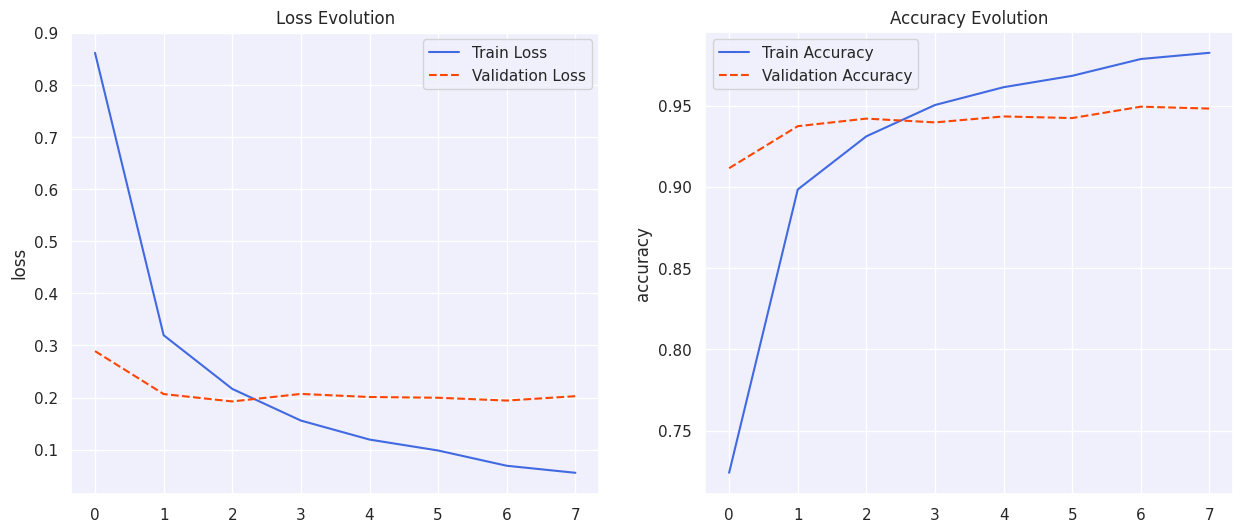

In [22]:
plot_learning_curves(history, start_epoch=1)

In [23]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())
    predictions = model.predict(val_generator, steps=len(val_generator))
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = val_generator.classes
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

48/48 [==============================] - 28s 540ms/step
              precision    recall  f1-score   support

buah_sayuran       0.93      0.93      0.93       301
        daun       0.97      0.99      0.98       301
  elektronik       0.99      0.97      0.98       301
        kaca       0.93      0.96      0.95       301
      kertas       0.94      0.92      0.93       301
       logam       0.92      0.94      0.93       301
     makanan       0.93      0.94      0.94       301
       medis       0.96      0.95      0.96       301
     plastik       0.91      0.90      0.90       301
     tekstil       0.98      0.98      0.98       301

    accuracy                           0.95      3010
   macro avg       0.95      0.95      0.95      3010
weighted avg       0.95      0.95      0.95      3010





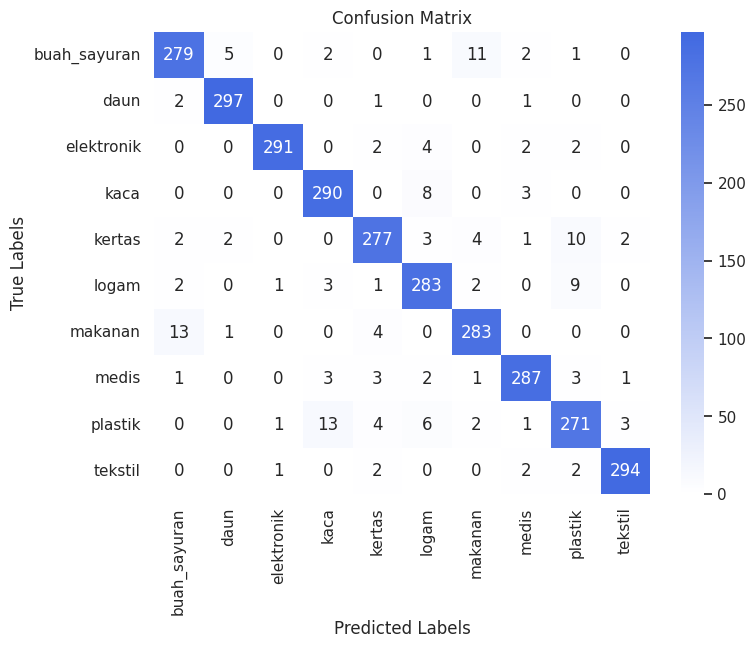

In [25]:
class_labels = list(test_generator.class_indices.keys())
evaluate_model_performance(model, test_generator, class_labels)

# Continue training and take the best val loss

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001, verbose=1),
    EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True, verbose=1)
]

checkpoint_callback = ModelCheckpoint(
    'robin_efficientnetv2s.keras', 
    monitor='val_loss', 
    mode='min', 
    save_best_only=True, 
    verbose=1
)

In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30,
    initial_epoch=8,
    callbacks=[callbacks, checkpoint_callback]
)

Epoch 9/30


KeyboardInterrupt: 

48/48 [==============================] - 11s 220ms/step
              precision    recall  f1-score   support

buah_sayuran       0.95      0.91      0.93       301
        daun       0.98      0.98      0.98       301
  elektronik       0.99      0.98      0.99       301
        kaca       0.94      0.97      0.95       301
      kertas       0.96      0.96      0.96       301
       logam       0.94      0.97      0.95       301
     makanan       0.91      0.95      0.93       301
       medis       0.97      0.97      0.97       301
     plastik       0.95      0.89      0.92       301
     tekstil       0.99      0.99      0.99       301

    accuracy                           0.96      3010
   macro avg       0.96      0.96      0.96      3010
weighted avg       0.96      0.96      0.96      3010





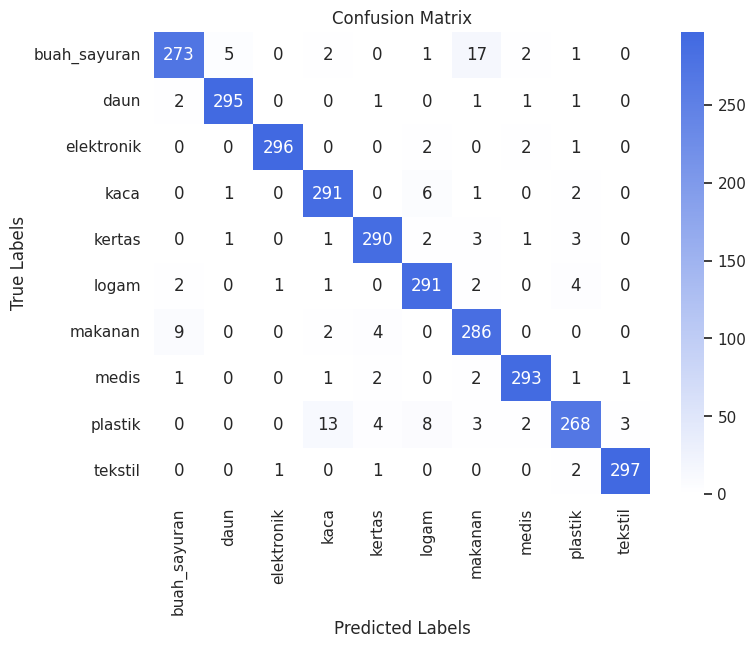

In [31]:
class_labels = list(test_generator.class_indices.keys())
evaluate_model_performance(model, test_generator, class_labels)

# Testing the model

In [41]:
import random

def plot_random_predictions(model, test_dir, class_labels, num_images=36, seed=None):
    """
    Plot a grid of random predictions for test images from different class folders.

    Parameters:
    - model: The trained model.
    - test_dir: Path to the test dataset directory.
    - class_labels: List of class labels.
    - num_images: Number of random images to display.
    - seed: Seed for random number generation (optional).
    """

    random.seed(seed)

    class_folders = [os.path.join(test_dir, class_label) for class_label in class_labels]

    fig, axs = plt.subplots(6, 6, figsize=(15, 15))
    axs = axs.ravel()

    for i in range(num_images):
        random_class = random.choice(class_folders)
        random_image_path = random.choice([os.path.join(random_class, img) for img in os.listdir(random_class) if img.endswith(('jpg', 'jpeg', 'png'))])

        true_label = os.path.basename(random_class)

        with Image.open(random_image_path) as img:
            axs[i].imshow(img)
            axs[i].axis('off')

            img_resized = img.resize((224, 224))
            img_array = np.expand_dims(np.array(img_resized), axis=0)
            img_array = preprocess_input(img_array)

            prediction = model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence_score = np.max(prediction)

            axs[i].set_title(f"True: {true_label}\nPredicted: {predicted_class}\nConfidence: {confidence_score:.2f}")

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 38ms/step


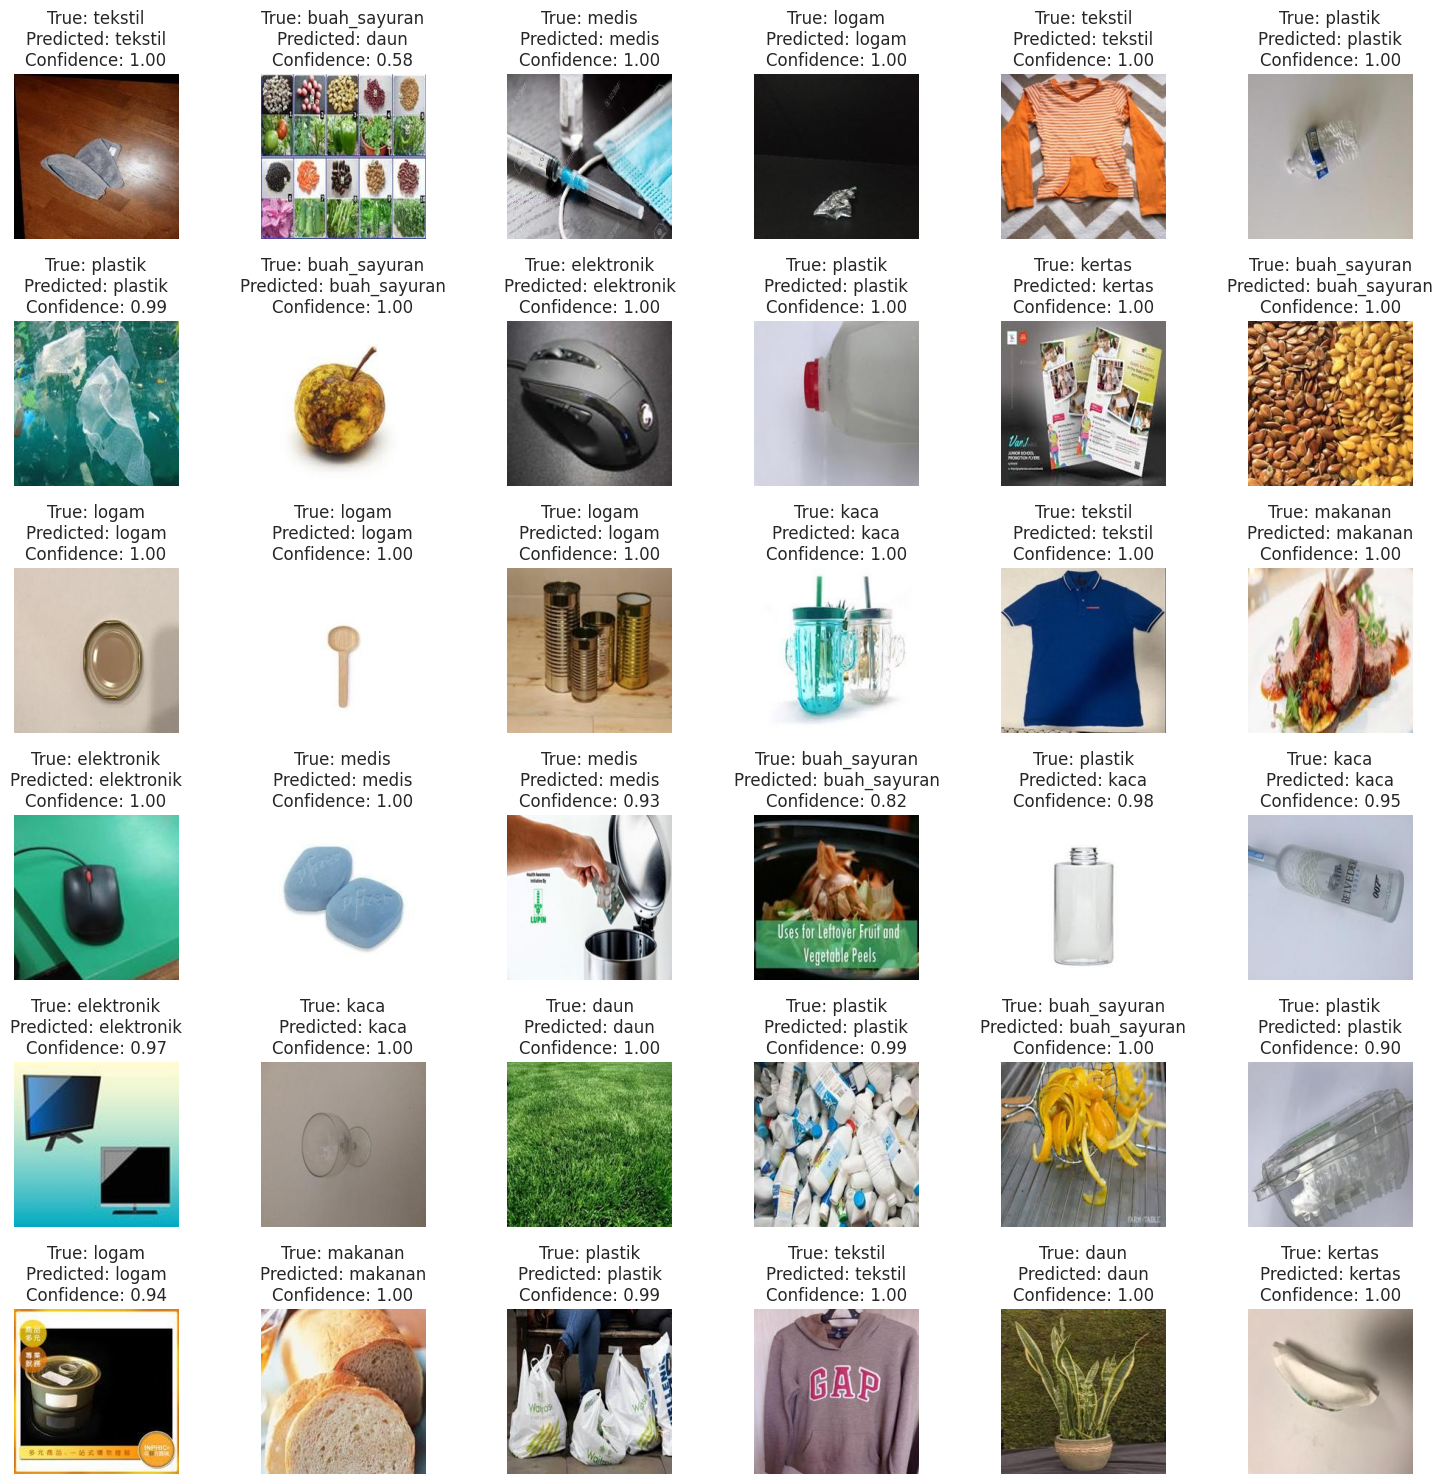

In [42]:
plot_random_predictions(model, test_dir, class_labels)

In [44]:
import shutil

saved_path = "/kaggle/working/robin_efficientnetv2s"

In [46]:
model.save(saved_path, save_format="tf")
print(f"Model saved to {saved_path}")

Model saved to /kaggle/working/robin_efficientnetv2s


In [47]:
output_zip_path = "/kaggle/working/robin_efficientnetv2s.zip"

shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', saved_path)
print(f"Model zipped and saved at {output_zip_path}")

Model zipped and saved at /kaggle/working/robin_efficientnetv2s.zip


In [48]:
model_save_keras = "./robin_efficientnetv2s.keras"
model.save(model_save_keras)
print(f"Saved to {model_save_keras}")

Saved to ./robin_efficientnetv2s.keras
